In [2]:
import polars as pl
import pandas as pd

pl.Config.set_fmt_str_lengths(200)
pl.Config.set_fmt_float("full")

polars.config.Config

In [3]:
df_filepaths = 'data/univ3/*.parquet'

In [4]:
def get_largest_tokenIn_vol(df_filepaths: str, blockchain: str) -> pl.DataFrame:
    q = (
        pl.scan_parquet(df_filepaths)
        .filter(pl.col("blockchain") == blockchain)
        .groupby('tokenIn_symbol')
        .agg(pl.col("amountInUSD").sum())
        .sort(by="amountInUSD", descending=True)
    )
    df = q.collect()

    # add blockchain column
    df = df.with_columns(pl.lit(blockchain).alias('blockchain'))
    
    return df

def get_largest_tokenIn_vol(df_filepaths: str, blockchain: str) -> pl.DataFrame:
    q = (
        pl.scan_parquet(df_filepaths)
        .filter(pl.col("blockchain") == blockchain)
        .groupby('tokenIn_symbol')
        .agg(pl.col("amountInUSD").sum())
        .sort(by="amountInUSD", descending=True)
    )
    df = q.collect()

    # add blockchain column
    df = df.with_columns(pl.lit(blockchain).alias('blockchain'))

    # rename column
    df = df.select(
        pl.col('tokenIn_symbol').alias('token'),
        pl.col('amountInUSD').alias('volume'),
        pl.col('blockchain')
    )

    return df

def get_largest_tokenOut_vol(df_filepaths: str, blockchain: str) -> pl.DataFrame:
    q = (
        pl.scan_parquet(df_filepaths)
        .filter(pl.col("blockchain") == blockchain)
        .groupby('tokenOut_symbol')
        .agg(pl.col("amountOutUSD").sum())
        .sort(by="amountOutUSD", descending=True)
    )
    df = q.collect()

    # add blockchain column
    df = df.with_columns(pl.lit(blockchain).alias('blockchain'))

    # rename column
    df = df.select(
        pl.col('tokenOut_symbol').alias('token'),
        pl.col('amountOutUSD').alias('volume'),
        pl.col('blockchain')
    )

    return df

def get_all_token_vol(df_filepaths: str, blockchain: str) -> pl.DataFrame:
    df_in = get_largest_tokenIn_vol(df_filepaths, blockchain)
    df_out = get_largest_tokenOut_vol(df_filepaths, blockchain)

    # concat
    df = pl.concat([df_in, df_out])

    # groupby token and sum volume again
    df = df.groupby('token').agg(pl.col('volume').sum()).sort(by='volume', descending=True)

    # add blockchain column
    df = df.with_columns(pl.lit(blockchain).alias('blockchain'))
    
    return df

In [5]:
eth_data = get_all_token_vol(df_filepaths, 'ethereum')
arb_data = get_all_token_vol(df_filepaths, 'arbitrum')
opt_data = get_all_token_vol(df_filepaths, 'optimism')
poly_data = get_all_token_vol(df_filepaths, 'polygon')
bsc_data = get_all_token_vol(df_filepaths, 'bsc')

PARTITIONED DS
PARTITIONED DS
PARTITIONED DS
PARTITIONED DS
PARTITIONED DS
PARTITIONED DS
PARTITIONED DS
PARTITIONED DS
PARTITIONED DS
PARTITIONED DS


In [14]:
# bsc doesn't have 'weth', they have binance pegged eth with symbol ETH.
bsc_data = bsc_data.with_columns(
    pl.when(pl.col('token') == 'ETH').then(pl.lit('WETH')).otherwise(pl.col('token')).alias('token')
)

# do the same with BTCB and WBTC
bsc_data = bsc_data.with_columns(
    pl.when(pl.col('token') == 'BTCB').then(pl.lit('WBTC')).otherwise(pl.col('token')).alias('token')
)

In [24]:
bsc_data

token,volume,blockchain
str,f64,str
"""USDT""",3549365859.108866,"""bsc"""
"""WBNB""",3180452379.6744385,"""bsc"""
"""BUSD""",1770758068.6413813,"""bsc"""
"""USDC""",753137094.1134765,"""bsc"""
"""WBTC""",745370427.427084,"""bsc"""
"""WETH""",437452878.813754,"""bsc"""
"""Cake""",310329590.3438013,"""bsc"""
"""EDU""",43789957.759197995,"""bsc"""
"""XRP""",27272461.21868752,"""bsc"""


In [16]:
# concat data
token_vol_df = pl.concat([eth_data, arb_data, opt_data, poly_data, bsc_data])

# sort
token_vol_df = token_vol_df.sort(by="volume", descending=True)

### Plotting

In [27]:
token_vol_df_pandas = token_vol_df.head(30).to_pandas()

In [28]:
# pivot blockchain column to column headers. Make token the index
pivot_df = token_vol_df_pandas.pivot(index='token', columns='blockchain', values='volume')

In [29]:
# create a new sum column
pivot_df['sum'] = pivot_df.sum(axis=1)

In [30]:
pivot_df = pivot_df.sort_values(by='sum', ascending=True)

In [31]:
pivot_df

blockchain,arbitrum,bsc,ethereum,optimism,polygon,sum
token,,,,,,
BLUR,NaN,NaN,4.546620e+08,NaN,NaN,4.546620e+08
LDO,NaN,NaN,5.772269e+08,NaN,NaN,5.772269e+08
OP,NaN,NaN,NaN,6.185773e+08,NaN,6.185773e+08
cbETH,NaN,NaN,6.416645e+08,NaN,NaN,6.416645e+08
GMX,6.899956e+08,NaN,NaN,NaN,NaN,6.899956e+08
HEX,NaN,NaN,1.103339e+09,NaN,NaN,1.103339e+09
BUSD,NaN,1.770758e+09,NaN,NaN,NaN,1.770758e+09
PEPE,NaN,NaN,1.977353e+09,NaN,NaN,1.977353e+09
WMATIC,NaN,NaN,NaN,NaN,2.708363e+09,2.708363e+09


In [32]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import thanefield_charting as tc

# Format the y-axis tick labels
def format_y_ticks(value, pos):
    if value >= 1e9:
        return f'${value / 1e9:.1f}B'
    elif value >= 1e6:
        return f'${value / 1e6:.1f}M'
    elif value >= 1e3:
        return f'${value / 1e3:.1f}K'
    else:
        return f'${value:.0f}'


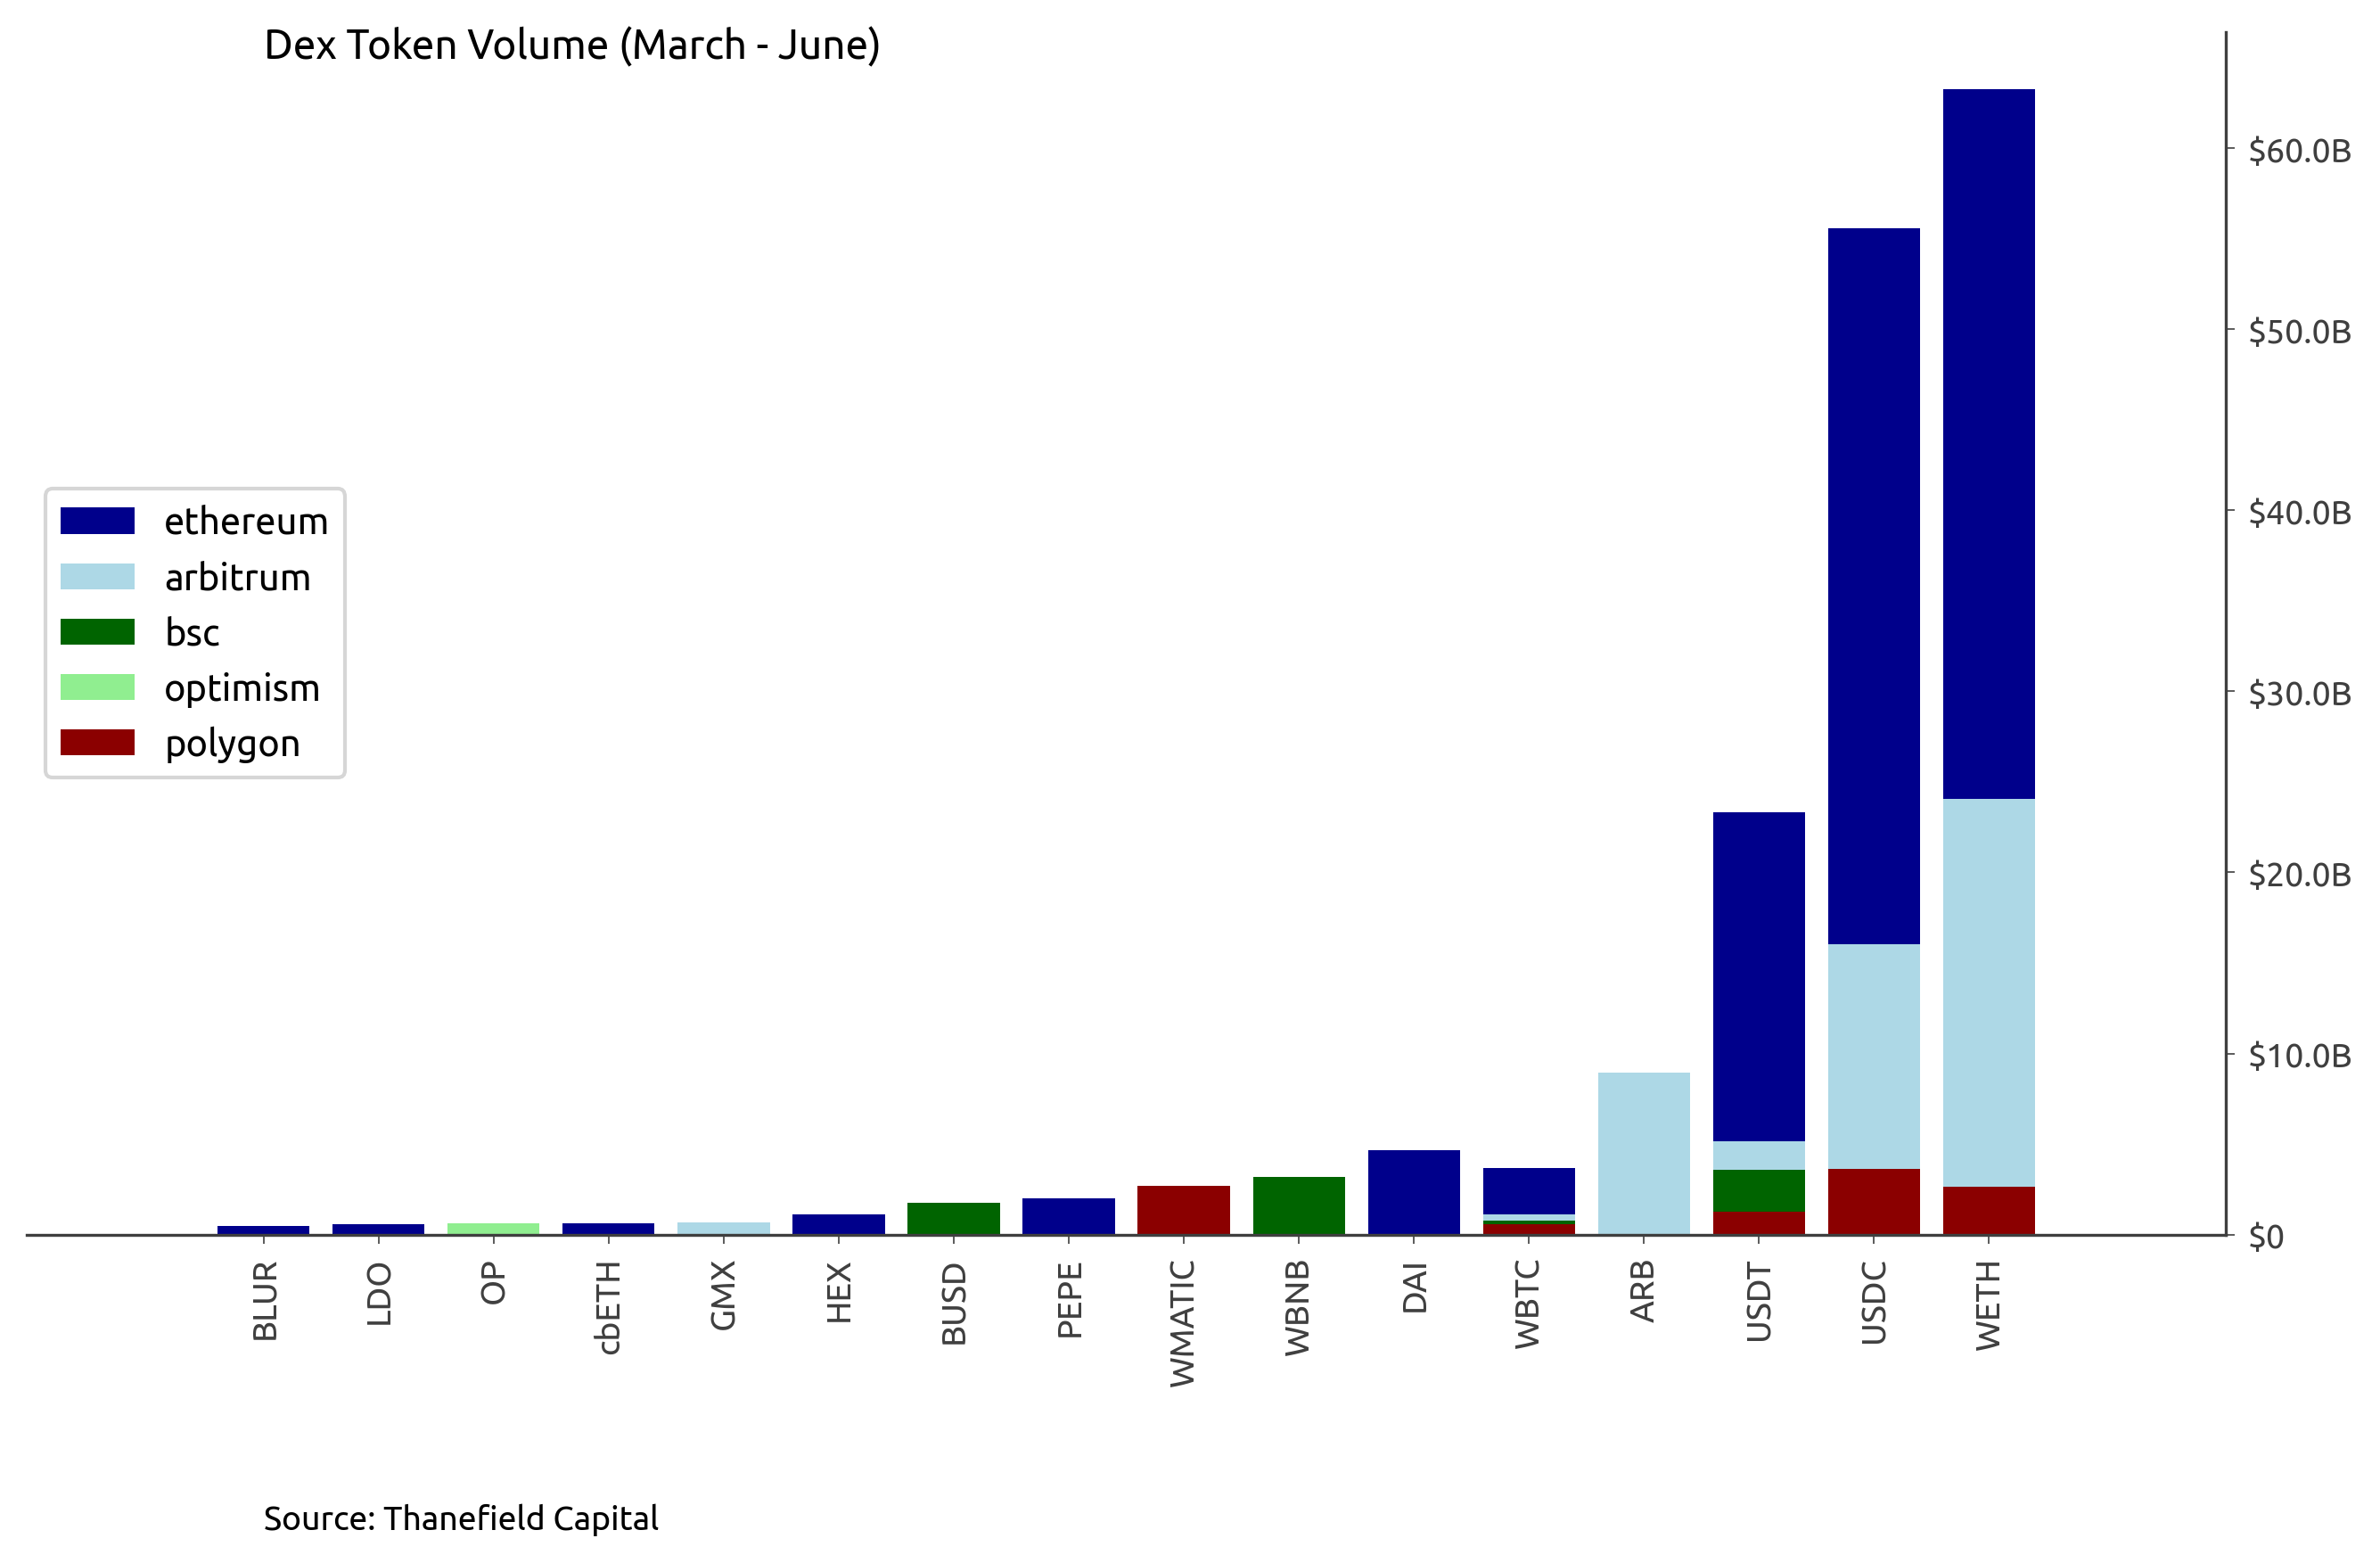

In [33]:
# note each token has over 1b volume
fig, ax = tc.chart('Dex Token Volume (March - June)', dates=False)

ax.bar(pivot_df.index, pivot_df['ethereum'], color='darkblue', label='ethereum')
ax.bar(pivot_df.index, pivot_df['arbitrum'], color='lightblue', label='arbitrum')
ax.bar(pivot_df.index, pivot_df['bsc'], color='darkkhaki', label='bsc')
ax.bar(pivot_df.index, pivot_df['optimism'], color='darkred', label='optimism')
ax.bar(pivot_df.index, pivot_df['polygon'], color='indigo', label='polygon')

# Apply the custom formatting function to the y-axis
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_y_ticks))

# formatting
# tc.legend(ax)
tc.set_xmargin(ax, margin=.05)
plt.tight_layout()
plt.xticks(rotation=90)
plt.legend(loc='center left')

# save chart
tc.save('charts/dex_total_token_vol.png')